
# Mobile Marketing Targeting Strategy  
### Profit-Based Push Notification Decisions

**Role:** Marketing Data Analyst  
**Focus:** ROI, customer attention cost, targeting strategy  

This project evaluates how a mobile marketing team should decide **who to message** when push notifications
create both revenue *and* customer fatigue.


In [1]:
import polars as pl
import pyrsm as rsm
import pandas as pd
import numpy as np

# you can import additional python packages but only use packages that
# are already part of the docker container

In [2]:
# Use this dataset and notebook to answer questions 1-13
tuango = pd.read_parquet("data/tuango_pre.parquet")

In [3]:
# dataset description
tuango_description = rsm.md("data/tuango_pre_description.md")

# Tuango: Targeting Mobile App Push Messages

This file contains information about the test and does not have results about the roll-out. Values for `buyer` and `ordersize` are missing for all customers that were not part of the test.

## Variable Names and Descriptions
* userid: Unique user ID

**Response to the customized push message**
* buyer: Did the customer buy the Karaoke deal? ("yes" or "no")
* ordersize: Number of 30-minute Karaoke sessions the customer purchased

**Recency, Frequency, and Monetary variables**
* recency: Days since last purchase of a deal (before the Karaoke deal offer)
* frequency: Number of deals purchased during the one year period before the Karaoke deal offer
* monetary: Average amount spent per order (in RMB) during the one year period before the Karaoke deal offer

**Other variables in the dataset**
* age: Age of the customer
* gender: Gender identity of the customer (M = male, F = female, O = Other or unknown)
* music: Customer made a purchase in the music category during the one-year period before the Karaoke deal offer ("no" or "yes")
* test: Splits the dataset into test (1) and rollout (0) data
* training: Splits the dataset into training (1) and test (0) data. This variable will not be used in this assignment

In [ ]:
tuango.buyer.value_counts(dropna=False)

buyer
NaN    397252
no      18888
yes      2020
Name: count, dtype: int64

In [5]:
tuango.buyer.isna().value_counts()

buyer
True     397252
False     20908
Name: count, dtype: int64

In [6]:
tuango["buyer_yes"] = tuango["buyer"].map({"yes": 1, "no": 0})

tuango.buyer_yes.value_counts(dropna=False)

buyer_yes
NaN    397252
0       18888
1        2020
Name: count, dtype: int64


## 1. Business Context & Decision Problem

Mobile push notifications are often treated as having zero marginal cost.  
In reality, excessive or irrelevant messages reduce customer lifetime value by increasing opt-outs.

**Decision question**
> Should we send a promotional message to *all* interested customers, or only to those whose **expected profit exceeds the cost of interruption**?


In [7]:
q1 = (tuango[tuango["test"] == 1]["buyer_yes"] == 1).mean()

q1

np.float64(0.09661373636885402)


## 2. Experimental Design & Data

A randomized test was conducted on customers who expressed interest in karaoke deals.

**Why this matters**
- Randomization allows causal estimation of response behavior
- A held-out rollout sample enables *true performance validation*


In [8]:
# (1) counts the number of yes and no, (2) the mean ordersize, and
# (3) the standard deviation in ordersize for yes and no responses
q2 = tuango.pivot_table(
    values="ordersize", index="buyer", aggfunc=["count", "mean", "std"]
)

q2.loc["yes", "mean"]

/tmp/ipykernel_13501/2242534685.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  q2 = tuango.pivot_table(
/tmp/ipykernel_13501/2242534685.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  q2 = tuango.pivot_table(
/tmp/ipykernel_13501/2242534685.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  q2 = tuango.pivot_table(


ordersize    3.941089
Name: yes, dtype: float64


## 3. Baseline Demand: How Customers Respond Without Targeting

I will do it later to use not targeting customers as a baseline model in a more business language.



## 4. Modeling Purchase Probability (Who Is Likely to Buy)

I estimate a logistic regression to model the probability that a customer purchases the deal after receiving a push notification.

**Marketing interpretation**
This model answers: *Who is worth interrupting?*


In [9]:
import pyrsm as rsm

In [10]:
clf = rsm.model.logistic(
    data={"tuango": tuango},
    rvar="buyer",
    lev="yes",
    evar=["recency", "frequency", "monetary", "age", "gender", "music"],
)
clf.summary()

Logistic regression (GLM)
Data                 : tuango
Response variable    : buyer
Level                : yes
Explanatory variables: recency, frequency, monetary, age, gender, music
Null hyp.: There is no effect of x on buyer
Alt. hyp.: There is an effect of x on buyer

               OR     OR%  coefficient  std.error  z.value p.value     
Intercept   0.051  -94.9%       -2.977      0.097  -30.768  < .001  ***
gender[F]   1.731   73.1%        0.549      0.054   10.073  < .001  ***
gender[O]   1.078    7.8%        0.075      0.128    0.584   0.559     
music[yes]  1.908   90.8%        0.646      0.059   10.912  < .001  ***
recency     0.999   -0.1%       -0.001      0.000   -3.292  < .001  ***
frequency   1.114   11.4%        0.108      0.010   10.861  < .001  ***
monetary    1.002    0.2%        0.002      0.000   12.499  < .001  ***
age         0.988   -1.2%       -0.012      0.001   -9.115  < .001  ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Pseudo R-squar


## 5. Interpreting Drivers of Response

Partial Dependence and Permutation Importance analyses are used to understand:

- Which customer characteristics increase responsiveness
- Which variables matter most for targeting decisions

This ensures the model is **interpretable and actionable**, not just predictive.



## 6. Modeling Conditional Demand (How Much They Buy)

Among customers who convert, I estimate a linear regression to model order size.

**Why this matters**
Expected revenue depends not only on conversion, but also on **purchase depth**.


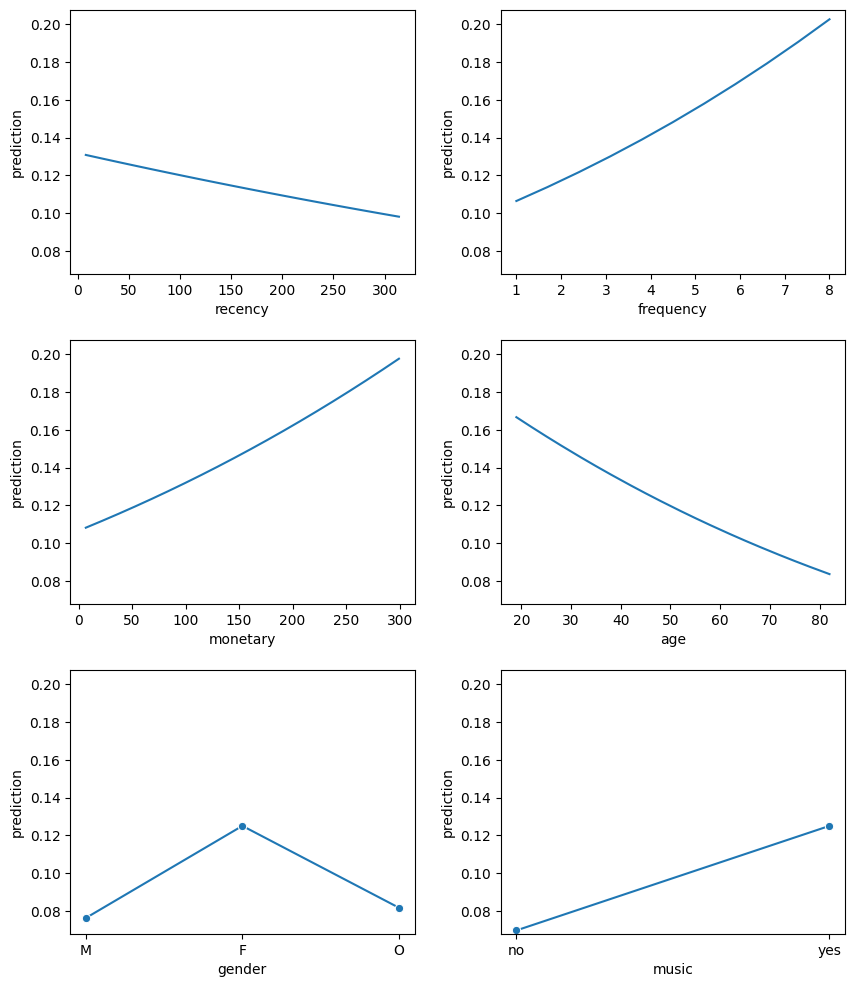

In [11]:
clf.plot("pred")


## 7. From Predictions to Expected Revenue

Model predictions are combined to calculate **expected revenue per customer**:

> Expected Revenue =  
> Purchase Probability × Expected Order Size × Price × Platform Fee

This translation step connects analytics directly to financial outcomes.



## 8. Unit Economics & Break-Even Logic

Sending a push notification has a real marginal cost due to customer fatigue.

I derive a **break-even response threshold**:
- Customers below this threshold destroy value
- Customers above it generate positive expected profit


In [12]:
clf.plot("pip")

![alt text](image.png)


## 9. Strategy Comparison: Target-All vs Profit-Based Targeting

Two strategies are evaluated:
1. **Target everyone**
2. **Target only customers above the break-even threshold**

Metrics:
- Total profit
- Return on Marketing Expenditure (ROME)



## 10. Visualization of Profitability

Bar charts are used to communicate:
- Absolute profit differences
- Efficiency improvements from targeting

This format is designed for stakeholder decision-making.


In [13]:
tuango["pred_logit"] = clf.predict()["prediction"]

In [14]:
estimate = tuango[tuango["test"] == 1]

In [15]:
print(f"response rate: {(estimate['buyer'] == 'yes').mean()}")

print(f"average of predicted values on training set: {estimate['pred_logit'].mean()}")

response rate: 0.09661373636885402
average of predicted values on training set: 0.09661373636885406



## 11. Rollout Validation (Realized Performance)

Using post-campaign data, I evaluate **actual realized profit and ROME**.

This step confirms whether model-based targeting delivers real-world gains.



## 12. Managerial Takeaways

- Customer attention is **not free**
- Profit-based targeting materially improves ROI
- Simple economic thresholds outperform blanket messaging
- Analytics should guide *who* to contact, not just *what* to send

**Recommendation:**  
Adopt profit-based targeting as the default strategy for mobile campaigns.


In [16]:
place_order = tuango[tuango["buyer"] == "yes"].copy()

In [17]:
reg = rsm.model.regress(
    data={"tuango": place_order},
    rvar="ordersize",
    evar=["recency", "frequency", "monetary", "age", "gender", "music"],
)

In [18]:
reg.plot("pip")

In [19]:
reg.summary(vif=True)

Linear regression (OLS)
Data                 : tuango
Response variable    : ordersize
Explanatory variables: recency, frequency, monetary, age, gender, music
Null hyp.: the effect of x on ordersize is zero
Alt. hyp.: the effect of x on ordersize is not zero

            coefficient  std.error  t.value p.value     
Intercept         3.665      0.174   21.104  < .001  ***
gender[F]         0.126      0.089    1.425   0.154     
gender[O]         0.259      0.208    1.243   0.214     
music[yes]        0.025      0.097    0.255   0.799     
recency           0.000      0.001    0.591   0.555     
frequency         0.023      0.016    1.456   0.145     
monetary          0.000      0.000    1.035   0.301     
age               0.001      0.003    0.389   0.697     

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-squared: 0.003, Adjusted R-squared: -0.0
F-statistic: 0.939 df(7, 2012), p.value 0.475
Nr obs: 2,020

Variance inflation factors:

             vif    Rsq
gende

In [20]:
tuango["pred_ordersize"] = reg.predict(tuango)["prediction"]

In [21]:
print(
    f"average ordersize of the predicted values: {(tuango[tuango['buyer'] == 'yes']['pred_ordersize']).mean()}"
)
print(f"average ordersize: {(tuango[tuango['buyer'] == 'yes']['ordersize']).mean()}")

average ordersize of the predicted values: 3.9410891089108846
average ordersize: 3.9410891089108913


In [22]:
q2

,count,mean,std
,ordersize,ordersize,ordersize
buyer,,,
yes,2020,3.941089,1.701904
no,18888,0.000000,0.000000


In [23]:
# state your assumptions that are relevant to calculate
# the breakeven response rate
# breakeven should be of type `float`

cost = 9.0  # float
margin = float(49 * 0.5 * q2.loc["yes", "mean"])  # float
breakeven = float(
    cost / margin
)  # float, do not apply rounding, do not express as a percentage
q11 = breakeven  # float, DO NOT APPLY ROUNDING, do not express as a percentage
q11

/tmp/ipykernel_13501/3354405636.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  margin = float(49 * 0.5 * q2.loc["yes", "mean"])  # float


0.09320949834524941

In [24]:
# insert calculation code here
# all variables should be numeric (integer or float) and of length 1
# _all stands for 'targeting all'
tuango["message_all"] = True

rollout = tuango[tuango["buyer_yes"].isna()]
test_sample = tuango[tuango["test"] == 1]
test_response = len(test_sample[test_sample["buyer_yes"] == 1]) / len(test_sample)

nr_message_all = (
    rollout["message_all"]
).sum()  # total number of messages that would be sent out
message_cost_all = (
    9.0 * nr_message_all
)  # total cost of sending messages to selected customers (float)
nr_responses_all = test_response * len(rollout)  # total number of positive responses
response_rate_all = (
    nr_responses_all / nr_message_all
)  # expressed as a proportion (no rounding)
revenue_all = float(
    49 * q2.loc["yes", "mean"] * nr_responses_all
)  # total revenue in RMB (no rounding)
profit_all = (
    revenue_all * 0.5 - message_cost_all
)  # 0.5 * revenue - message_cost_all = total profit in RMB (no rounding)
rome_all = (
    profit_all / message_cost_all
)  # Return on Marketing Expenditures expressed as a proportion (no rounding)

print(profit_all)
print(rome_all)

130577.5
0.036522436919414154


/tmp/ipykernel_13501/2693871725.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  revenue_all = float(


In [25]:
# find the ppl in test sample with probability exceeds breakeven and buy the deal
test = tuango[tuango["test"] == 1].copy()
high_prob_buyer = test[(test["pred_logit"] > breakeven) & (test["buyer"] == "yes")]

# recalculate pivot table
finetune = high_prob_buyer.pivot_table(
    values="ordersize", index="buyer", aggfunc=["count", "mean"]
)
ordersize = float(finetune.loc["yes", "mean"])
finetune

/tmp/ipykernel_13501/1329819060.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  finetune = high_prob_buyer.pivot_table(
/tmp/ipykernel_13501/1329819060.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  finetune = high_prob_buyer.pivot_table(
/tmp/ipykernel_13501/1329819060.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ordersize = float(finetune.loc["yes", "mean"])


,count,mean
,ordersize,ordersize
buyer,,
yes,1329,3.969902
no,0,NaN


In [26]:
targeted = test_sample[test_sample["pred_logit"] > breakeven]
targeted_response = len(targeted[targeted["buyer_yes"] == 1]) / len(targeted)

In [27]:
tuango["message_logit"] = tuango["pred_logit"] > breakeven
rollout = tuango[tuango["test"] == 0]

nr_message_logit = rollout[
    "message_logit"
].sum()  # total number of messages that would be sent out
message_cost_logit = (
    9.0 * nr_message_logit
)  # total cost of sending messages to selected customers (float)
nr_responses_logit = (
    rollout["pred_logit"] > breakeven
).sum() * targeted_response  # total number of positive responses
response_rate_logit = (
    nr_responses_logit / nr_message_logit
)  # expressed as a proportion (no rounding)
revenue_logit = float(
    49 * ordersize * nr_responses_logit
)  # total revenue in RMB (no rounding)
profit_logit = (
    0.5 * revenue_logit - message_cost_logit
)  # 0.5 * revenue_logit - message_cost_logit = total profit in RMB (no rounding)
rome_logit = (
    profit_logit / message_cost_logit
)  # Return on Marketing Expenditures expressed as a proportion (no rounding)

print(profit_logit)
print(rome_logit)

881237.0444903732
0.5623239904758452


In [28]:
from plotnine import (
    ggplot,
    aes,
    geom_line,
    geom_hline,
    geom_col,
    geom_text,
    geom_histogram,
    labs,
)

In [29]:
# create new Dataframe with plooting data
bins = ["No targeting", "Targeting"]

performance_data = pl.DataFrame(
    {
        "name": pl.Series(bins).cast(pl.Enum(bins)),
        "Profit": [profit_all, profit_logit],
        "ROME": [rome_all, rome_logit],
    }
)


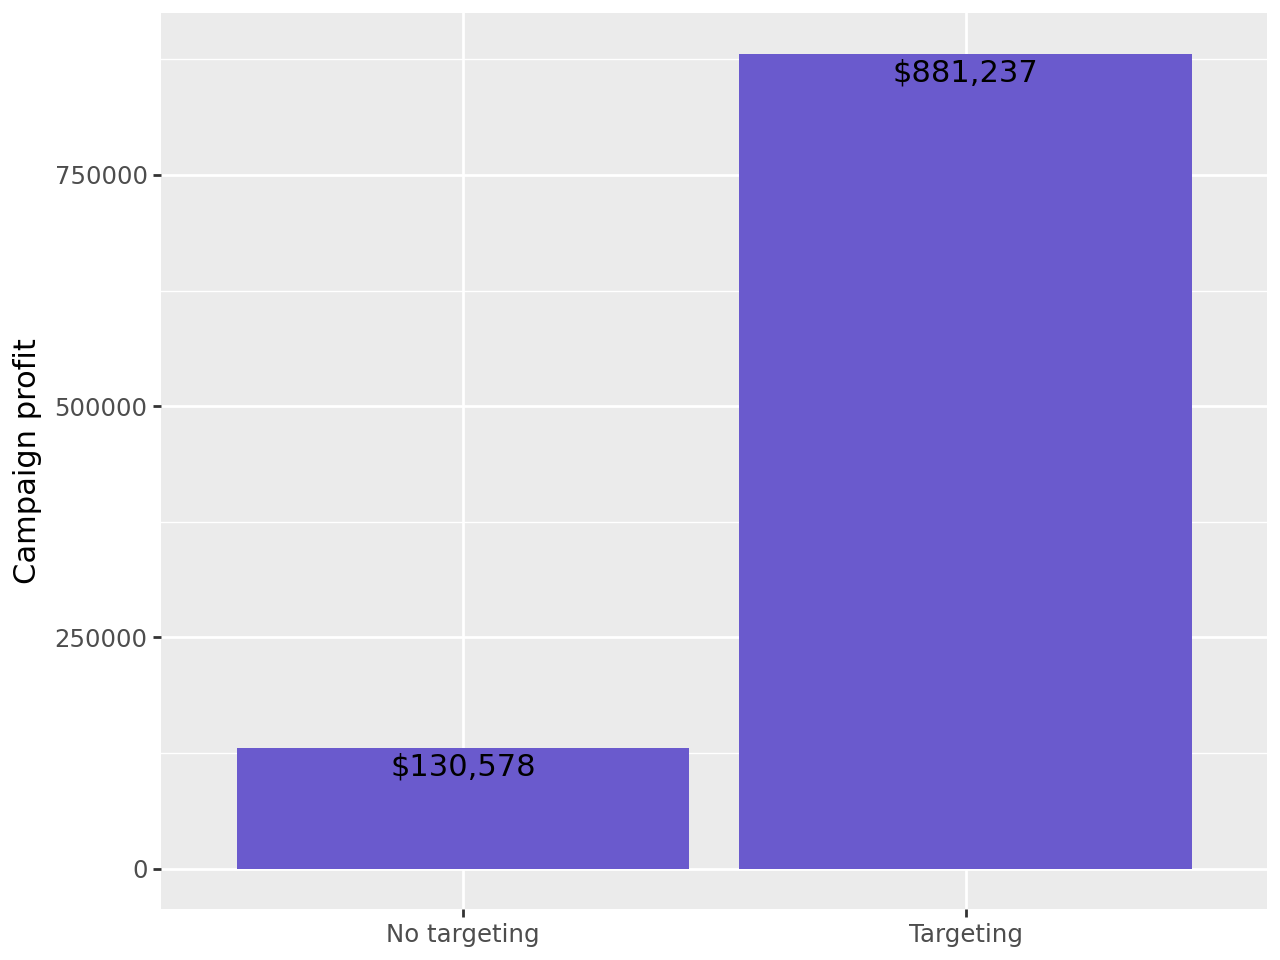

In [30]:
(
    ggplot(performance_data, aes(x="name", y="Profit"))
    + geom_col(fill="slateblue")
    + geom_text(
        aes(label="Profit"),
        format_string="${:,.0f}",
        va="top",
        nudge_y=-5000,
        color="black",
    )
    + labs(x="", y="Campaign profit")
)


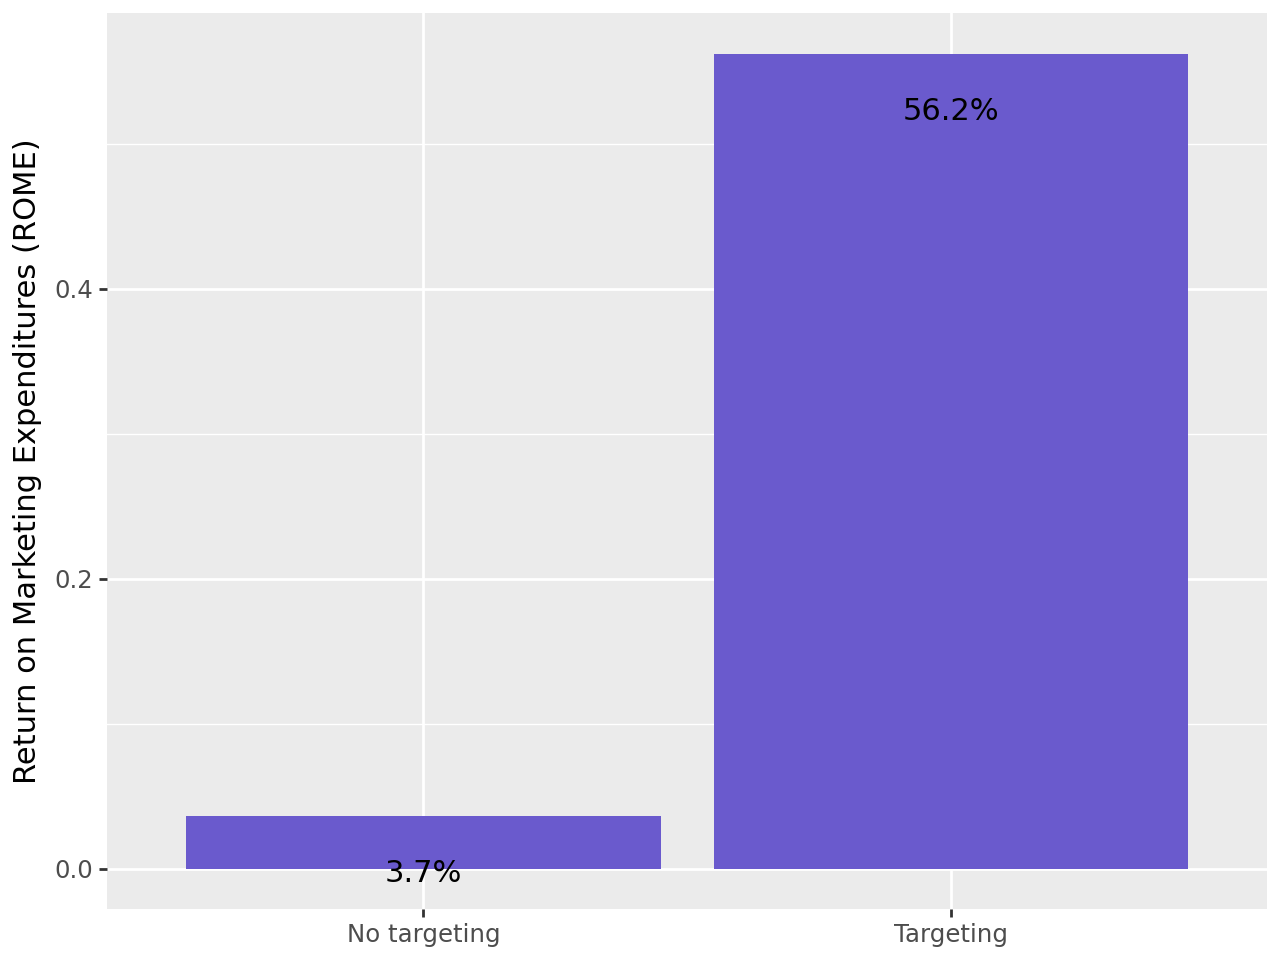

In [31]:
(
    ggplot(performance_data, aes(x="name", y="ROME"))
    + geom_col(fill="slateblue")
    + geom_text(
        aes(label="ROME"),
        format_string="{:.1%}",
        va="top",
        nudge_y=-0.03,
        color="black",
    )
    + labs(x="", y="Return on Marketing Expenditures (ROME)")
)


In [32]:
df = pd.read_parquet("data/tuango_post.parquet")
df.head()

,userid,buyer,ordersize,recency,frequency,monetary,age,gender,music,training,test
0,U15889344,no,0.0,309,7.0,39.799999,44,F,yes,0.0,1
1,U60246497,no,0.0,297,8.0,39.799999,80,M,yes,1.0,1
2,U22965759,no,0.0,295,1.0,72.900002,59,F,yes,1.0,1
3,U40811142,no,0.0,277,1.0,40.000000,37,F,yes,0.0,1
4,U76283952,no,0.0,259,1.0,21.000000,43,F,yes,1.0,1


In [33]:
rollout = df[df["test"] == 0].copy()

In [34]:
rollout[rollout["buyer"] == "no"]["ordersize"].sum()

np.float64(0.0)

In [35]:
# total number of messages that would be sent out
nr_message = len(rollout)

# total cost of sending messages to selected customers (float)
message_cost = 9.0 * nr_message

# total number of positive responses
nr_responses = (rollout["buyer"] == "yes").sum()

# expressed as a proportion (no rounding)
response_rate = nr_responses / nr_message


# total revenue in RMB (no rounding)
revenue = (rollout["ordersize"]).sum() * 49
profit = 0.5 * revenue - message_cost
rome = profit / message_cost

print(profit)
print(rome)


111712.5
0.031245909397561247


In [36]:
df["pred_logit"] = tuango["pred_logit"]
rollout1 = df[df["test"] == 0]
rollout1["message_send"] = rollout1["pred_logit"] > breakeven
rollout1.head()

/tmp/ipykernel_13501/135493588.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,userid,buyer,ordersize,recency,frequency,monetary,age,gender,music,training,test,pred_logit,message_send
20908,U78589602,no,0.0,8,1.0,115.330000,71,F,yes,NaN,0,0.092104,False
20909,U83705520,no,0.0,274,1.0,58.000000,46,F,yes,NaN,0,0.083355,False
20910,U59772099,no,0.0,185,8.0,123.599998,46,O,yes,NaN,0,0.134632,True
20911,U22464840,no,0.0,127,3.0,87.810000,46,M,no,NaN,0,0.041179,False
20912,U36020329,no,0.0,31,8.0,95.000000,33,F,yes,NaN,0,0.244048,True


In [37]:
targeted = rollout1[rollout1["pred_logit"] > breakeven]

In [38]:
# total number of messages that would be sent out
nr_message_target = rollout1["message_send"].sum()

# total cost of sending messages to selected customers (float)
message_cost_target = 9.0 * nr_message_target

# total number of positive responses
nr_responses_target = (targeted["buyer"] == "yes").sum()

# expressed as a proportion (no rounding)
response_rate_target = nr_responses_target / nr_message_target


# total revenue in RMB (no rounding)
revenue_target = (targeted["ordersize"]).sum() * 49
profit_target = 0.5 * revenue_target - message_cost_target
rome_target = profit_target / message_cost_target

print(profit_target)
print(rome_target)


887423.0
0.5662712952434189


In [39]:
# create new Dataframe with plooting data
bins = ["No targeting", "Targeting"]

performance_data = pl.DataFrame(
    {
        "name": pl.Series(bins).cast(pl.Enum(bins)),
        "Profit": [profit, profit_target],
        "ROME": [rome, rome_target],
    }
)

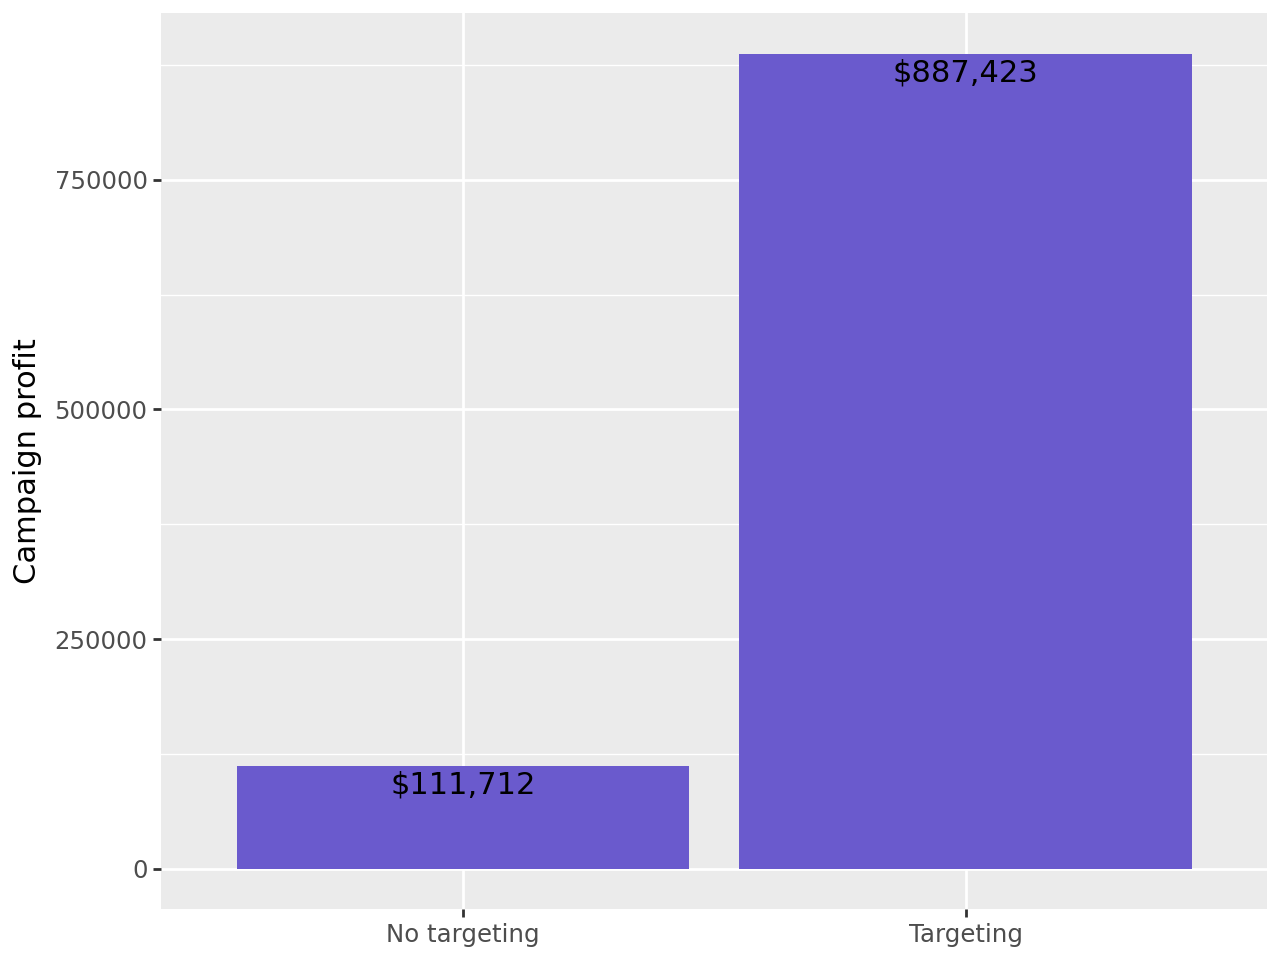

In [40]:
(
    ggplot(performance_data, aes(x="name", y="Profit"))
    + geom_col(fill="slateblue")
    + geom_text(
        aes(label="Profit"),
        format_string="${:,.0f}",
        va="top",
        nudge_y=-5000,
        color="black",
    )
    + labs(x="", y="Campaign profit")
)


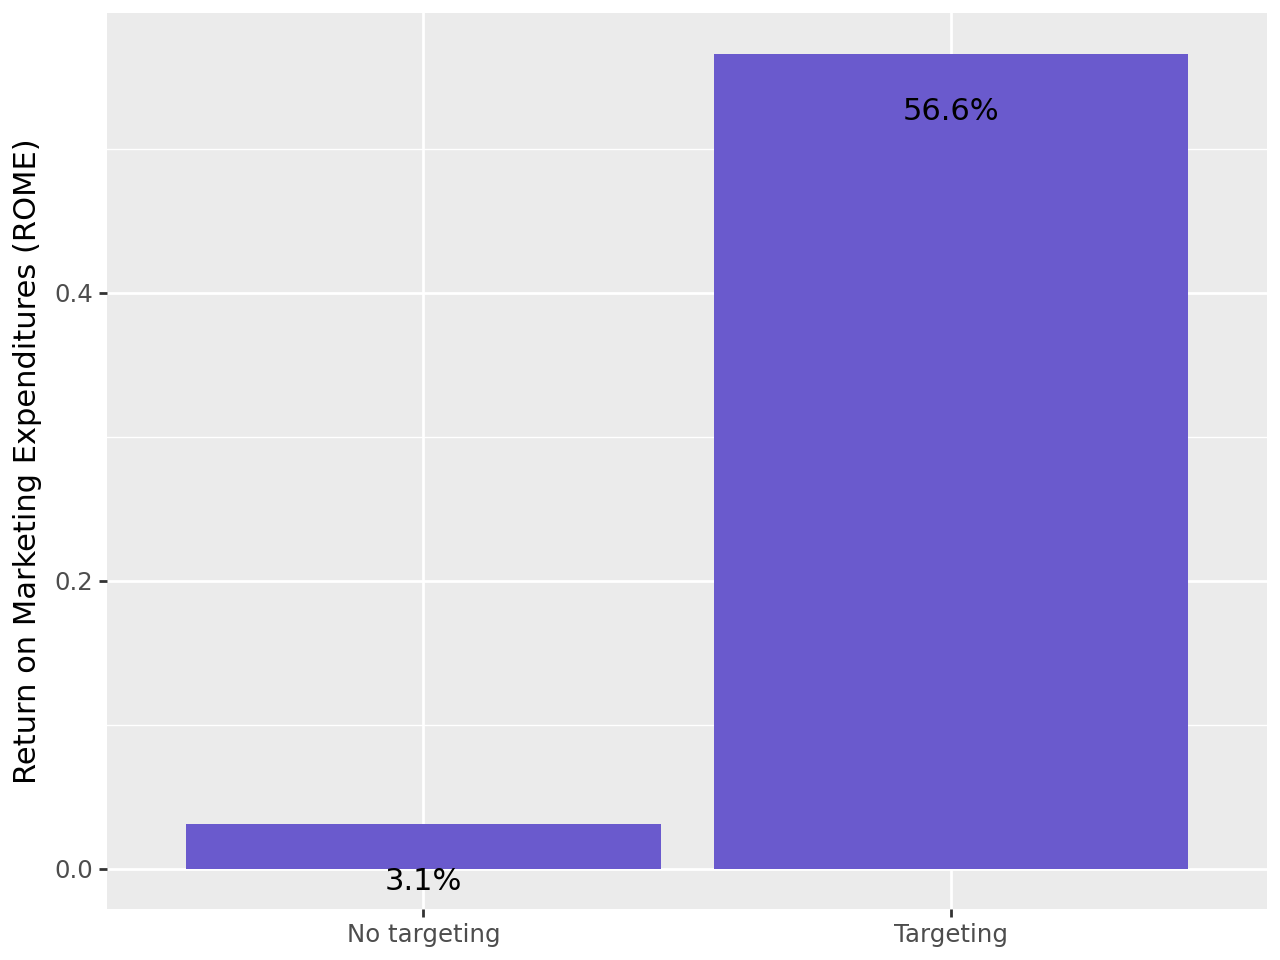

In [41]:
(
    ggplot(performance_data, aes(x="name", y="ROME"))
    + geom_col(fill="slateblue")
    + geom_text(
        aes(label="ROME"),
        format_string="{:.1%}",
        va="top",
        nudge_y=-0.03,
        color="black",
    )
    + labs(x="", y="Return on Marketing Expenditures (ROME)")
)
